In [1]:
import sys

sys.path.append("..")
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from sklearn.model_selection import KFold
import numpy as np
from dory.classifier.mlp import MultilayerPerceptronClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
df = pd.read_csv("vowel.csv", header=None)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,-3.203740,1.881764,-0.507770,0.515483,-0.305658,0.630244,-0.004365,0.336553,-0.302976,-0.071339,5.000000
std,0.868987,1.175272,0.711948,0.759261,0.664602,0.603871,0.461927,0.573302,0.570162,0.603985,3.163876
min,-5.211000,-1.274000,-2.487000,-1.409000,-2.127000,-0.836000,-1.537000,-1.293000,-1.613000,-1.680000,0.000000
25%,-3.887750,1.051500,-0.975750,-0.065500,-0.769000,0.196000,-0.307000,-0.095750,-0.704000,-0.548000,2.000000
50%,-3.145500,1.876500,-0.572500,0.433500,-0.299000,0.552000,0.022000,0.328000,-0.302500,-0.156500,5.000000
75%,-2.602500,2.738000,-0.068750,1.096000,0.169500,1.028500,0.296500,0.770000,0.093750,0.371000,8.000000
max,-0.941000,5.074000,1.431000,2.377000,1.831000,2.327000,1.403000,2.039000,1.309000,1.396000,10.000000


In [3]:
random_state = 42069
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(792, 10) (198, 10) (792,) (198,)


In [4]:
param_dist = {
    "hidden_layer_sizes": [[i] for i in range(1, 100 + 1)],
    "learning_rate": np.logspace(np.log10(0.0001), np.log10(0.1), num=10),
    "momentum": np.linspace(0.9, 0.99, num=10),
}

model = MultilayerPerceptronClassifier(
    random_state=random_state, batch_size=32, should_validate=False, validation_size=0.1
)
splits = 5
n_iter = 100

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=n_iter,
    cv=splits,
    random_state=random_state,
    n_jobs=-1,
    verbose=1,
)

random_search

,estimator,MultilayerPer...tion_size=0.1)
,param_distributions,"{'hidden_layer_sizes': [[1], [2], ...], 'learning_rate': array([0.0001..., 0.1 ]), 'momentum': array([0.9 , ..., 0.98, 0.99])}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42069
,error_score,nan


In [5]:
random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_
best_model

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/flemis/codes/dory/lista_04/../dory/classifier/mlp.py:127: RuntimeWarning: overflow encountered in matmul
  delta_next @ weight_next_l_no_bias
/home/flemis/codes/dory/lista_04/../dory/classifier/mlp.py:126: RuntimeWarning: invalid value encountered in multiply
  delta_l = (self.__derivative_activation(U_layer)) * (
/home/flemis/codes/dory/lista_04/../dory/classifier/mlp.py:137: RuntimeWarning: overflow encountered in matmul
  gradient = delta.T @ previous_layer_activation
/home/flemis/codes/dory/lista_04/../dory/classifier/mlp.py:137: RuntimeWarning: invalid value encountered in matmul
  gradient = delta.T @ previous_layer_activation
/home/flemis/codes/dory/lista_04/../dory/classifier/mlp.py:155: RuntimeWarning: overflow encountered in matmul
  U = Z[-1] @ weight.T  # U Shape: (batch_size, n_neurons)
/home/flemis/codes/dory/lista_04/../dory/classifier/mlp.py:127: RuntimeWarning: overflow encountered in matmul
  delta_next @ weight_next_l_no_bias
/home/flemis/codes/dory/lista_04/..

Best parameters found:  {'momentum': np.float64(0.9400000000000001), 'learning_rate': np.float64(0.046415888336127774), 'hidden_layer_sizes': [88]}


,hidden_layer_sizes,[88]
,batch_size,32
,max_iter,200
,random_state,42069
,learning_rate,np.float64(0....5888336127774)
,momentum,np.float64(0.9400000000000001)
,validation_size,0.1
,shuffle,True
,should_validate,False
,epsilon,1e-08


In [15]:
model = MultilayerPerceptronClassifier(**random_search.best_params_, should_validate=True, validation_size=0.2)
model.set_params(should_validate=True)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

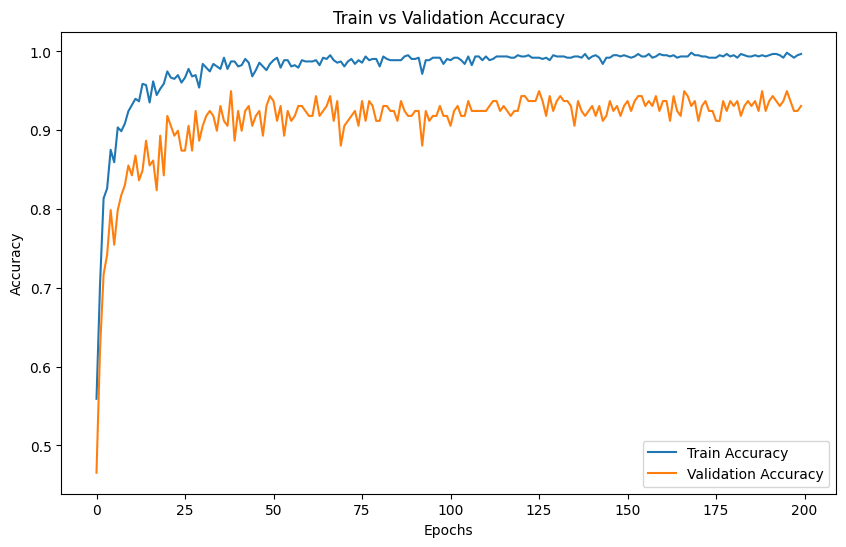

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_errors_['acc'], label='Train Accuracy')
plt.plot(model.val_errors_['acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

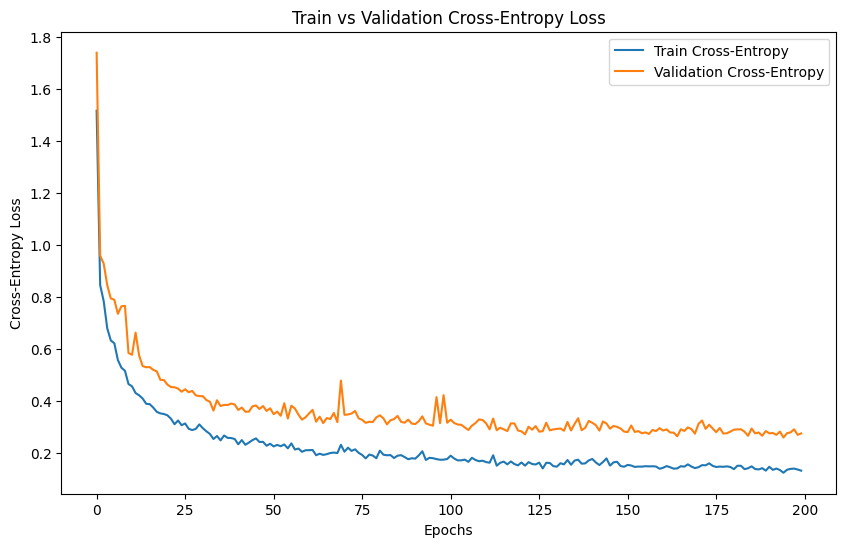

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_errors_['cross-entropy'], label='Train Cross-Entropy')
plt.plot(model.val_errors_['cross-entropy'], label='Validation Cross-Entropy')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Train vs Validation Cross-Entropy Loss')
plt.legend()
plt.show()

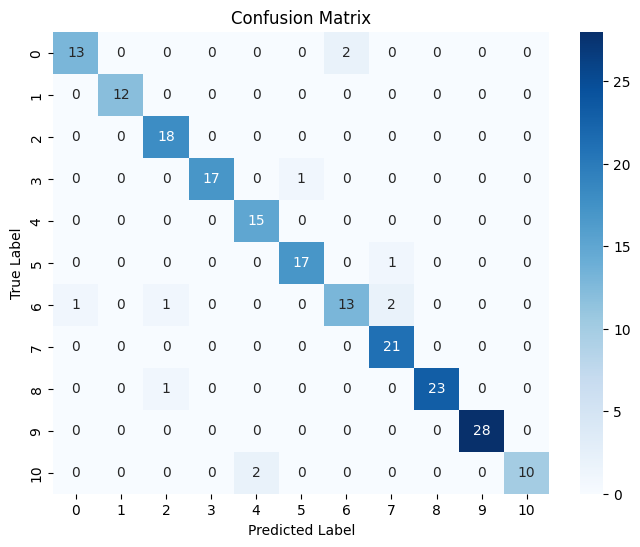

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [19]:
train_acc = model.train_errors_['acc'].iloc[-1]
val_acc = model.val_errors_['acc'].iloc[-1]
test_acc = accuracy_score(y_test, y_pred)

print(f"Final Train Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Final Train Accuracy: 0.9968
Final Validation Accuracy: 0.9308
Test Accuracy: 0.9444
